In [1]:
%load_ext autoreload
%autoreload 2
import datalib as dl
import params as p
import talib
import numpy as np
import nn
import backtest as bt
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials

In [2]:
p.load_config('ETHUSDROC')


**************** Loaded Config for ETHUSDROC ****************


In [5]:
eth = dl.load_data('ETH', 'USD')
btc = dl.load_data('BTC', 'USD')

Loaded ETHUSD prices from KRAKEN via cc Rows:1844 Date:2020-08-23 00:00:00
Last complete day close: 395.52
Loaded BTCUSD prices from KRAKEN via cc Rows:2514 Date:2020-08-23 00:00:00
Last complete day close: 11672.7


In [6]:
prices = {'ETH': eth, 'BTC': btc}

In [7]:
def test_model(m):
    columns = ['date', 'open', 'close', 'y_pred_val', 'DR']
    m['ETH'] = m['ETH'][columns]
    m['BTC'] = m['BTC'][columns]
    m['BTC']['y_pred_val'] = 0

    basket = pd.merge(m['ETH'], m['BTC'], on='date', how='left', suffixes=('_ETH','_BTC')).sort_values('date')
    basket['buy_signals'] = basket['y_pred_val_ETH'] + basket['y_pred_val_BTC']
    basket['share_ETH'] = np.where(basket['y_pred_val_ETH'] == 1, 1/basket['buy_signals'], 0)
    basket['share_BTC'] = np.where(basket['y_pred_val_BTC'] == 1, 1/basket['buy_signals'], 0)

    basket['DR'] = 0.5*basket['DR_ETH'] + 0.5*basket['DR_BTC']
    basket['CMR'] = np.cumprod(basket.DR)

    basket['SR'] = np.where(basket['buy_signals'] > 0, basket['share_ETH']*basket['DR_ETH'] + basket['share_BTC']*basket['DR_BTC'], 1)
    basket['CSR'] = np.cumprod(basket.SR)
    
#     bt.plot_chart(basket, 'basket', 'date')
    return basket.CSR.iloc[-1]

In [8]:
def run_model(prices=prices, rsi_period=14, roc_period=20, rsi_min=0, roc_min=0, sma1_period=10, sma2_period=10):
    markets = {}
    for coin in prices:
        ds = prices[coin]
        ds['DR'] = ds['close'] / ds['close'].shift(1)
        ds['RSI'] = talib.RSI(ds['close'].values, timeperiod = rsi_period)
        ds['ROC'] = talib.ROC(ds['close'].values, timeperiod = roc_period)
        ds['MA1'] = talib.SMA(ds['close'], timeperiod = sma1_period)
        ds['MA2'] = talib.SMA(ds['close'], timeperiod = sma2_period)
#         ds = ds[ds.date >= '2015-02-01']
        ds = ds.dropna()
#         y_pred_val = np.where((ds.RSI > rsi_min) & (ds.ROC > roc_min) & (ds.MA1 >= ds.MA2), 1, 0)
        y_pred_val = np.where(ds.ROC > roc_min, 1, 0)
        y_pred_val = y_pred_val[:-2]
        td = nn.gen_signal(ds, y_pred_val)
        markets[coin] = td
    
    csr = test_model(markets)
    return csr

In [14]:
def f(space):
    return -run_model(
#         rsi_period=space['rsi_period'], 
        roc_period=space['roc_period'], 
#         rsi_min=space['rsi_min'], 
        roc_min=space['roc_min'] 
#         sma1_period=space['sma1_period'], 
#         sma2_period=space['sma2_period']
    )
	
space = {
#     'rsi_period': hp.quniform('rsi_period', 2, 100, 1),
    'roc_period': hp.quniform('roc_period', 2, 100, 1),
#     'rsi_min': hp.quniform('rsi_min', 0, 100, 1),
    'roc_min': hp.quniform('roc_min', 0, 100, 1)
#     'sma1_period': hp.quniform('sma1_period', 2, 200, 1),
#     'sma2_period': hp.quniform('sma2_period', 2, 200, 1)
}

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

print(best)

  1%|          | 7/1000 [00:00<00:34, 29.01trial/s, best loss: -251.84033827995867]

/Users/igor/.local/share/virtualenvs/q-trader-FIeA7-di/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



100%|██████████| 1000/1000 [01:09<00:00, 14.31trial/s, best loss: -9357.893749289917]
{'roc_min': 0.0, 'roc_period': 18.0}


In [93]:
def get_best_trials(trials):
    loss = 0
    for t in trials:
        if t['result']['loss'] < loss:
            loss = t['result']['loss']
            print(loss)
            print(t['misc']['vals'])

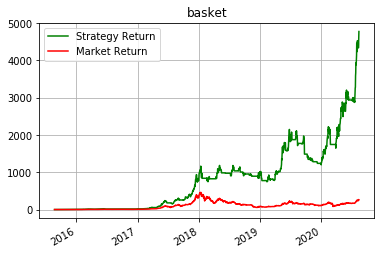

4777.503355005707

In [14]:
# Best ETH + BTC Model
run_model(roc_min = 3, roc_period = 16)

/Users/igor/.local/share/virtualenvs/q-trader-FIeA7-di/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


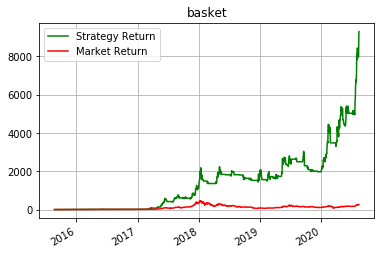

9295.142333722813

In [9]:
# Best ETH only model
run_model(roc_min = 2, roc_period = 16)

Results
+ ETH only model model performs better than ETH + BTC
+ Best parameters: roc_min = 2, roc_period = 16
+ SMA and RSI are not required

Position Sizing for Combo model:
+ Strategy Return: 68801.08
+ Market Return: 475.96
+ Sortino Ratio: 9.21

No position sizing for Combo model:
+ Strategy Return: 196456.69
+ Market Return: 475.95
+ Sortino Ratio: 8.24

Adding to Ensemble does not improve profit


Backtest

Using TensorFlow backend.



**************** Loaded Config for ETHUSDROC ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


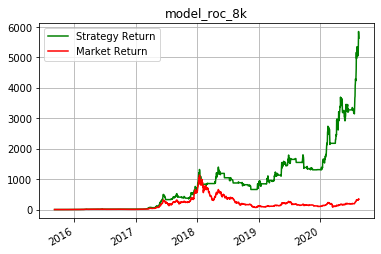

Strategy Return: 5633.66
Market Return: 342.19
Sortino Ratio: 4.18
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.62
Expectancy: 4.48
Sharpe Ratio: 2.34
Average Daily Return: 0.012
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.39%


In [1]:
import nn

In [ ]:
Ensemble

Using TensorFlow backend.



**************** Loaded Config for ETHUSDENS ****************

**************** Loaded Config for ETHUSDNN1 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


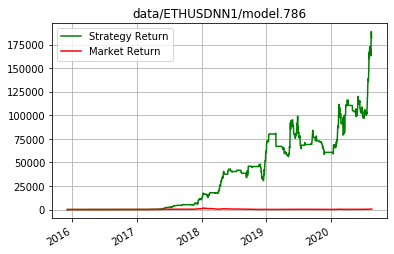

Strategy Return: 182161.07
Market Return: 491.57
Sortino Ratio: 7.25
Bars in Trade: 4
Buy Pct: 0.44
Accuracy: 0.56
Win Ratio: 0.59
Avg Win: 0.09
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.55
Sharpe Ratio: 3.33
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 84.44%

**************** Loaded Config for ETHUSDNN1S ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


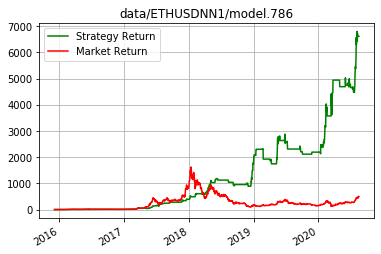

Strategy Return: 6610.04
Market Return: 491.57
Sortino Ratio: 5.96
Bars in Trade: 4
Buy Pct: 0.24
Accuracy: 0.56
Win Ratio: 0.58
Avg Win: 0.06
Avg Loss: 0.01
Risk to Reward: 4.44
Expectancy: 2.53
Sharpe Ratio: 2.84
Average Daily Return: 0.007
SL: 0.02 TP: 0.00
ETH/USD: Same Signal: Cash Open: 432.39

**************** Loaded Config for ETHUSDNN2 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


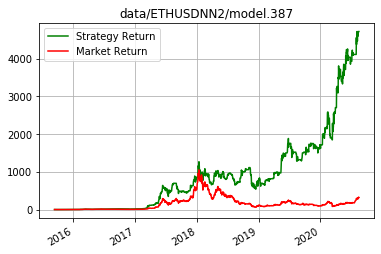

Strategy Return: 4723.02
Market Return: 318.34
Sortino Ratio: 3.84
Bars in Trade: 4
Buy Pct: 0.55
Accuracy: 0.56
Win Ratio: 0.61
Avg Win: 0.06
Avg Loss: 0.03
Risk to Reward: 2.23
Expectancy: 2.50
Sharpe Ratio: 2.16
Average Daily Return: 0.007
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%

**************** Loaded Config for ETHUSDROC ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


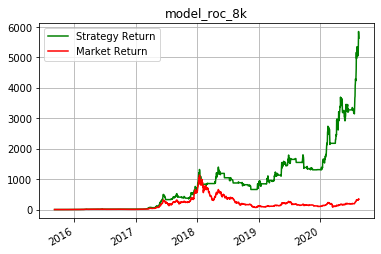

Strategy Return: 5633.66
Market Return: 342.19
Sortino Ratio: 4.18
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.62
Expectancy: 4.48
Sharpe Ratio: 2.34
Average Daily Return: 0.012
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.39%

**************** Loaded Config for ETHUSDENS ****************


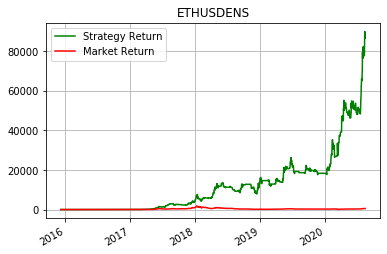

Strategy Return: 86599.60
Market Return: 535.13
Sortino Ratio: 5.66
Bars in Trade: 5
Buy Pct: 0.55
Accuracy: 0.57
Win Ratio: 0.59
Avg Win: 0.12
Avg Loss: 0.03
Risk to Reward: 4.63
Expectancy: 4.78
Sharpe Ratio: 2.95
Average Daily Return: 0.013
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.59%


In [1]:
import nn

Original Ensemble (Risk+Safe+Moon)

Using TensorFlow backend.



**************** Loaded Config for ETHUSDENS ****************

**************** Loaded Config for ETHUSDNN1 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


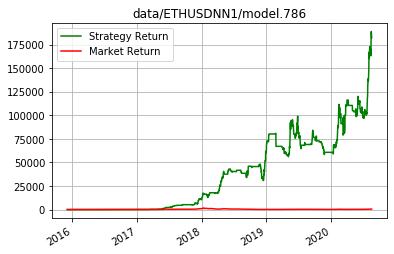

Strategy Return: 182338.12
Market Return: 492.05
Sortino Ratio: 7.25
Bars in Trade: 4
Buy Pct: 0.44
Accuracy: 0.56
Win Ratio: 0.59
Avg Win: 0.09
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.55
Sharpe Ratio: 3.33
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 84.62%

**************** Loaded Config for ETHUSDNN1S ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


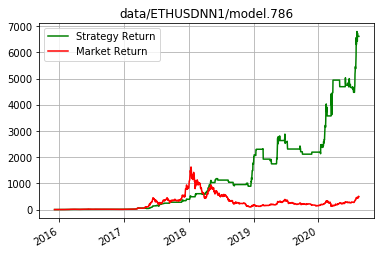

Strategy Return: 6610.04
Market Return: 490.34
Sortino Ratio: 5.96
Bars in Trade: 4
Buy Pct: 0.24
Accuracy: 0.56
Win Ratio: 0.58
Avg Win: 0.06
Avg Loss: 0.01
Risk to Reward: 4.44
Expectancy: 2.53
Sharpe Ratio: 2.84
Average Daily Return: 0.007
SL: 0.02 TP: 0.00
ETH/USD: Same Signal: Cash Open: 432.39

**************** Loaded Config for ETHUSDNN2 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


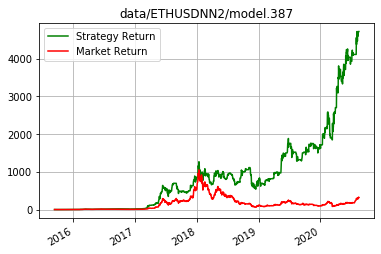

Strategy Return: 4723.02
Market Return: 317.54
Sortino Ratio: 3.84
Bars in Trade: 4
Buy Pct: 0.55
Accuracy: 0.56
Win Ratio: 0.61
Avg Win: 0.06
Avg Loss: 0.03
Risk to Reward: 2.23
Expectancy: 2.50
Sharpe Ratio: 2.16
Average Daily Return: 0.007
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%

**************** Loaded Config for ETHUSDENS ****************


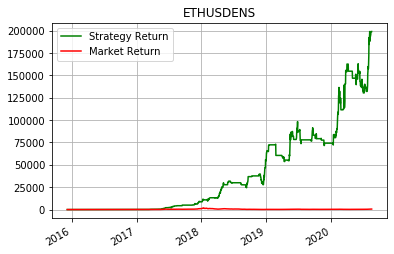

Strategy Return: 199108.56
Market Return: 535.65
Sortino Ratio: 8.24
Bars in Trade: 4
Buy Pct: 0.35
Accuracy: 0.57
Win Ratio: 0.61
Avg Win: 0.08
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.48
Sharpe Ratio: 3.51
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%


In [1]:
import nn

Loaded ETHUSD prices from KRAKEN via cc Rows:1844 Date:2020-08-23 00:00:00
Last complete day close: 395.52


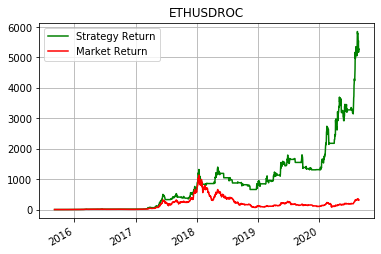

Strategy Return: 5276.09
Market Return: 314.83
Sortino Ratio: 4.14
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.44
Expectancy: 4.44
Sharpe Ratio: 2.32
Average Daily Return: 0.012
SL: 0.00 TP: 0.00


In [10]:
td = nn.runNN3()

In [3]:
def run_model(ticker, currency, period=16, threshold=2, delay=2):
    p.ticker = ticker
    p.currency = currency
    p.roc_period = period
    p.roc_threshold = threshold
    p.signal_delay = delay
    
    td = nn.runNN3()

    return td.CSR.iloc[-1]

In [4]:
p.load_config('ETHBTCROC')


**************** Loaded Config for ETHBTCROC ****************


Loaded ETHBTC prices from KRAKEN via cc Rows:2051 Date:2021-03-18 00:00:00
Last complete day close: 0.03096


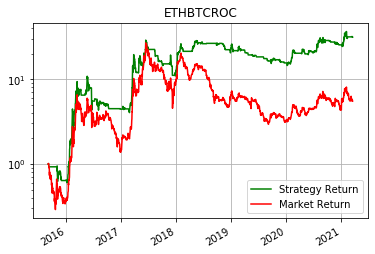

Strategy Return: 31.18
Market Return: 5.51
Sortino Ratio: 2.11
Bars in Trade: 11
Buy Pct: 0.44
Accuracy: 0.54
Win Ratio: 0.48
Avg Win: 0.14
Avg Loss: 0.03
Risk to Reward: 4.50
Expectancy: 1.74
Sharpe Ratio: 1.18
Average Daily Return: 0.005
SL: 0.00 TP: 0.00


In [6]:
td = nn.runNN3()

In [5]:
def f(space):
    print(space)
    return -run_model('ETH', 'BTC',
        period=int(space['period']), 
        threshold=space['threshold'], 
        delay=int(space['delay'])
    )

space = {
    'period': hp.quniform('period', 2, 50, 1),
    'threshold': hp.quniform('threshold', -20, 20, 1),
    'delay': hp.quniform('delay', 1, 10, 1)
}

trials = Trials()

In [6]:
p.charts = False
p.stats = False
p.reload = False

In [7]:
best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

print(best)

{'delay': 8.0, 'period': 46.0, 'threshold': 12.0}       
Using loaded prices for 2021-03-18                      
{'delay': 3.0, 'period': 6.0, 'threshold': 1.0}                                   
Using loaded prices for 2021-03-18                                                
{'delay': 9.0, 'period': 10.0, 'threshold': 7.0}                                  
Using loaded prices for 2021-03-18                                                
{'delay': 5.0, 'period': 20.0, 'threshold': 9.0}                                  
Using loaded prices for 2021-03-18                                                
{'delay': 8.0, 'period': 4.0, 'threshold': 7.0}                                   
Using loaded prices for 2021-03-18                                               
{'delay': 7.0, 'period': 19.0, 'threshold': -14.0}                               
Using loaded prices for 2021-03-18                                               
{'delay': 6.0, 'period': 42.0, 'threshold': -14.0}         

Using loaded prices for 2021-03-18                                                 
{'delay': 8.0, 'period': 19.0, 'threshold': 14.0}                                  
Using loaded prices for 2021-03-18                                                 
{'delay': 7.0, 'period': 8.0, 'threshold': 17.0}                                   
Using loaded prices for 2021-03-18                                                 
{'delay': 6.0, 'period': 11.0, 'threshold': 6.0}                                    
Using loaded prices for 2021-03-18                                                  
{'delay': 4.0, 'period': 4.0, 'threshold': 9.0}                                     
Using loaded prices for 2021-03-18                                                  
{'delay': 5.0, 'period': 11.0, 'threshold': 7.0}                                    
Using loaded prices for 2021-03-18                                                  
{'delay': 6.0, 'period': 46.0, 'threshold': 8.0}                      

Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 16.0, 'threshold': 15.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 4.0, 'threshold': 8.0}                                      
Using loaded prices for 2021-03-18                                                   
{'delay': 3.0, 'period': 23.0, 'threshold': 7.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 18.0, 'threshold': 13.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 11.0, 'threshold': 13.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 8.0, 'period': 35.0, 'threshold': 19.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 22.0, 'threshold': 16.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 12.0, 'threshold': 14.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 16.0, 'threshold': 10.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 27.0, 'threshold': 7.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 8.0, 'period': 9.0, 'threshold': 12.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 19.0, 'threshold': 13.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 18.0, 'threshold': 14.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 2.0, 'period': 20.0, 'threshold': 13.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 12.0, 'threshold': -6.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 8.0, 'period': 16.0, 'threshold': 20.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 15.0, 'threshold': 6.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 8.0, 'threshold': 12.0}      

Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 21.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 20.0, 'threshold': 18.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 19.0, 'threshold': -2.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 15.0, 'threshold': 13.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 25.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 13.0, 'threshold': 14.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 11.0, 'threshold': 17.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 17.0, 'threshold': 8.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 22.0, 'threshold': 5.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 13.0, 'threshold': 12.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 17.0, 'threshold': 14.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 18.0, 'threshold': 13.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 14.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 11.0, 'threshold': 3.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 12.0, 'threshold': -13.0}                                   
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 8.0, 'threshold': 7.0}                                      
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 16.0, 'threshold': 9.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 15.0, 'threshold': 4.0}      

Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 5.0, 'threshold': 13.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 13.0, 'threshold': 5.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 9.0, 'threshold': 6.0}                                      
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 18.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 16.0, 'threshold': -15.0}                                   
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 15.0, 'threshold': 10.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 22.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 11.0, 'threshold': 10.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 16.0, 'threshold': 14.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 17.0, 'threshold': 8.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 19.0, 'threshold': 7.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 13.0, 'threshold': 13.0}     

Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 21.0, 'threshold': 1.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 16.0, 'threshold': 8.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 5.0, 'period': 20.0, 'threshold': 11.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 7.0, 'period': 3.0, 'threshold': 14.0}                                     
Using loaded prices for 2021-03-18                                                   
{'delay': 6.0, 'period': 12.0, 'threshold': 10.0}                                    
Using loaded prices for 2021-03-18                                                   
{'delay': 4.0, 'period': 19.0, 'threshold': 17.0}     

In [9]:
p.charts = True
p.stats = True
p.reload = True

Loaded BTCUSD prices from KRAKEN via cc Rows:2721 Date:2021-03-18 00:00:00
Last complete day close: 58933.0


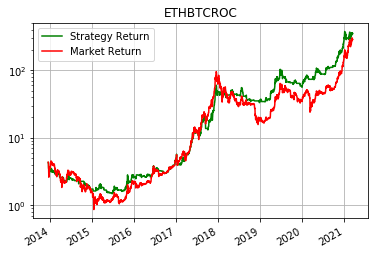

Strategy Return: 350.10
Market Return: 285.86
Sortino Ratio: 2.63
Bars in Trade: 9
Buy Pct: 0.58
Accuracy: 0.54
Win Ratio: 0.48
Avg Win: 0.10
Avg Loss: 0.02
Risk to Reward: 4.37
Expectancy: 1.38
Sharpe Ratio: 1.62
Average Daily Return: 0.004
SL: 0.00 TP: 0.00


350.0987212908541

In [18]:
# Best for BTC
run_model('BTC', 'USD', period=15, threshold=0, delay=5)

Loaded ETHUSD prices from KRAKEN via cc Rows:2051 Date:2021-03-18 00:00:00
Last complete day close: 1823.76


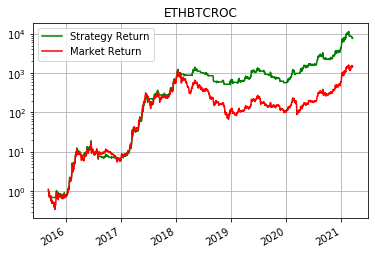

Strategy Return: 7621.75
Market Return: 1445.77
Sortino Ratio: 3.66
Bars in Trade: 11
Buy Pct: 0.65
Accuracy: 0.54
Win Ratio: 0.44
Avg Win: 0.36
Avg Loss: 0.03
Risk to Reward: 11.80
Expectancy: 4.84
Sharpe Ratio: 2.13
Average Daily Return: 0.013
SL: 0.00 TP: 0.00


7621.753640682379

In [15]:
# Best for ETH
# Tested in Ensemble: SR is not improved
run_model('ETH', 'USD', period=17, threshold=-5, delay=2)

In [1]:
# Tested Combo with ROC model and various thresholds -> did not beat the current Combo model

Loaded ETHBTC prices from KRAKEN via cc Rows:2051 Date:2021-03-18 00:00:00
Last complete day close: 0.03096


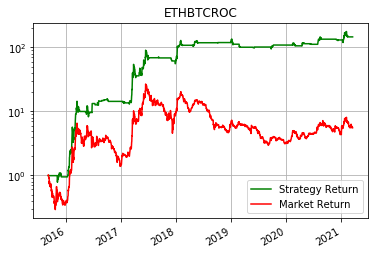

Strategy Return: 146.43
Market Return: 5.55
Sortino Ratio: 3.54
Bars in Trade: 18
Buy Pct: 0.25
Accuracy: 0.56
Win Ratio: 0.54
Avg Win: 0.21
Avg Loss: 0.02
Risk to Reward: 9.31
Expectancy: 2.18
Sharpe Ratio: 1.66
Average Daily Return: 0.006
SL: 0.00 TP: 0.00


146.42999102418807

In [10]:
# Best for ETHBTC
run_model('ETH', 'BTC', period=16, threshold=11, delay=6)


**************** Loaded Config for ETHBTCROC ****************
Loaded ETHBTC prices from KRAKEN via kr Rows:720 Date:2021-03-19 00:00:00
Last complete day close: 0.03081


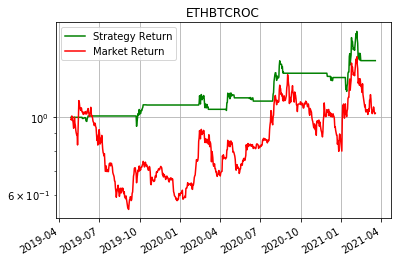

Strategy Return: 1.46
Market Return: 1.03
Sortino Ratio: 1.41
Bars in Trade: 20
Buy Pct: 0.19
Accuracy: 0.57
Win Ratio: 0.57
Avg Win: 0.03
Avg Loss: 0.01
Risk to Reward: 2.64
Expectancy: 0.22
Sharpe Ratio: 0.87
Average Daily Return: 0.001
SL: 0.00 TP: 0.00
ETH/BTC: Same Signal: Sell, Total PnL: 45.52%


,date,open,high,low,close,signal,ADX,PP,R1,S1,...,ctrf,SR,DR,CSR,CMR,y_pred,y_pred_val,y_pred_id,Price_Rise,date_to
time,,,,,,,,,,,,,,,,,,,,,
1556323200,2019-04-27,0.02978,0.03040,0.02962,0.03011,Sell,39.786363,0.030043,0.030467,0.029687,...,1.0,1.0,NaN,1.000000,NaN,False,0.0,0.0,0,2019-04-28
1556409600,2019-04-28,0.03006,0.03007,0.02969,0.02974,Sell,37.084170,0.029833,0.029977,0.029597,...,1.0,1.0,0.987712,1.000000,0.987712,False,0.0,0.0,0,2019-04-29
1556496000,2019-04-29,0.02973,0.02990,0.02929,0.02958,Sell,37.077079,0.029590,0.029890,0.029280,...,1.0,1.0,0.994620,1.000000,0.982398,False,0.0,0.0,0,2019-04-30
1556582400,2019-04-30,0.02965,0.03054,0.02963,0.03038,Sell,31.296831,0.030183,0.030737,0.029827,...,1.0,1.0,1.027045,1.000000,1.008967,False,0.0,0.0,1,2019-05-01
1556668800,2019-05-01,0.03037,0.03059,0.02961,0.02973,Sell,26.084837,0.029977,0.030343,0.029363,...,1.0,1.0,0.978604,1.000000,0.987380,False,0.0,0.0,0,2019-05-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615766400,2021-03-15,0.03135,0.03225,0.03073,0.03225,Sell,34.902759,0.031743,0.032757,0.031237,...,1.0,1.0,1.030022,1.455208,1.071073,False,0.0,0.0,1,2021-03-16
1615852800,2021-03-16,0.03225,0.03270,0.03154,0.03174,Sell,29.644983,0.031993,0.032447,0.031287,...,1.0,1.0,0.984186,1.455208,1.054135,False,0.0,0.0,0,2021-03-17
1615939200,2021-03-17,0.03175,0.03247,0.03095,0.03096,Sell,27.030849,0.031460,0.031970,0.030450,...,1.0,1.0,0.975425,1.455208,1.028230,False,0.0,0.0,0,2021-03-18


In [20]:
nn.runModel('ETHBTCROC')

In [14]:
286 * 146

41756


**************** Loaded Config for BTCUSDROC ****************
Loaded BTCUSD prices from KRAKEN via kr Rows:720 Date:2021-03-20 00:00:00
Last complete day close: 58101.8


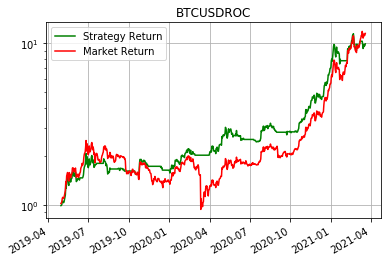

Strategy Return: 9.91
Market Return: 11.50
Sortino Ratio: 4.00
Bars in Trade: 9
Buy Pct: 0.64
Accuracy: 0.53
Win Ratio: 0.45
Avg Win: 0.09
Avg Loss: 0.01
Risk to Reward: 7.25
Expectancy: 1.43
Sharpe Ratio: 2.30
Average Daily Return: 0.004
SL: 0.00 TP: 0.00
BTC/USD: Same Signal: Buy, Total PnL: 891.49%


,date,open,high,low,close,signal,ADX,PP,R1,S1,...,ctrf,SR,DR,CSR,CMR,y_pred,y_pred_val,y_pred_id,Price_Rise,date_to
time,,,,,,,,,,,,,,,,,,,,,
1556323200,2019-04-27,5154.5,5216.5,5116.7,5168.5,Buy,67.766698,5167.233333,5217.766667,5117.966667,...,0.994705,0.994705,NaN,0.994705,NaN,True,1.0,1000.0,0,2019-04-28
1556409600,2019-04-28,5169.8,5215.4,5100.2,5158.9,Buy,66.789323,5158.166667,5216.133333,5100.933333,...,0.992850,0.998135,0.998143,0.992850,0.998143,True,1.0,1000.0,0,2019-04-29
1556496000,2019-04-29,5156.2,5194.2,5061.1,5149.0,Buy,66.340464,5134.766667,5208.433333,5075.333333,...,0.990937,0.998073,0.998081,0.990937,0.996227,True,1.0,1000.0,0,2019-04-30
1556582400,2019-04-30,5152.8,5297.0,5132.0,5273.0,Sell,61.761739,5234.000000,5336.000000,5171.000000,...,1.000000,1.000000,1.024082,0.990937,1.020219,False,0.0,0.0,1,2019-05-01
1556668800,2019-05-01,5272.2,5358.9,5270.0,5324.1,Buy,55.632114,5317.666667,5365.333333,5276.433333,...,1.001805,1.001805,1.009691,0.992726,1.030105,True,1.0,1000.0,1,2019-05-02
1556755200,2019-05-02,5323.2,5421.7,5311.3,5390.5,Buy,48.263698,5374.500000,5437.700000,5327.300000,...,1.014349,1.012521,1.012472,1.005156,1.042953,True,1.0,1000.0,1,2019-05-03
1556841600,2019-05-03,5390.0,5796.0,5368.7,5660.0,Buy,46.430823,5608.233333,5847.766667,5420.466667,...,1.065261,1.050193,1.049995,1.055607,1.095095,True,1.0,1000.0,1,2019-05-04
1556928000,2019-05-04,5658.8,5840.0,5525.0,5763.5,Sell,45.510497,5709.500000,5894.000000,5579.000000,...,1.000000,1.000000,1.018286,1.055607,1.115120,False,0.0,0.0,1,2019-05-05
1557014400,2019-05-05,5765.6,5779.9,5627.6,5719.3,Buy,44.743559,5708.933333,5790.266667,5637.966667,...,0.984002,0.984002,0.992331,1.038719,1.106569,True,1.0,1000.0,0,2019-05-06


In [2]:
nn.runModel('BTCUSDROC')